In [1]:
import matplotlib.pyplot as plt
from glob import glob

import cv2
import os
import numpy as np
import time
import base64
import codecs, json
import pickle

from PIL import Image


# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
#from keras_retinanet.utils.gpu import setup_gpu
from keras.models import Model



Using TensorFlow backend.


# test_input에 대해서 object detection 수행

In [2]:

# object detection
model_path = os.path.join('./keras-retinanet', 'snapshots', 'resnet50_coco_best_v2.1.0.h5')

dataset_path = "./original_test/"
output_path = "./detected_data/detected_from_test/"


retina_model = models.load_model(model_path, backbone_name='resnet50')
os.chdir(dataset_path)
dataset_list = os.listdir(os.getcwd())
os.chdir('../')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_1:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_2:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_3:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_4:0' shape=(9, 4) dtype=float32> anchors


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/plass-heesu/anaconda3/envs/tf1.15/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
from object_detection2 import object_detection
objectList = object_detection(retina_model, dataset_list, dataset_path, output_path)


handling person000518.png
image shape: (392, 640, 3)
resized image size: (800, 1306, 3) scale: 2.0408163265306123

(1, 300, 4) (1, 300) (1, 300)
processing time:  3.3081960678100586
detection 완료!


# detected object를 선택


In [4]:
selectedObject = objectList[1]
selectedObject_path = selectedObject["objectImagePath"]

In [5]:
selectedObject_pil = Image.open(selectedObject_path)


1. readTest 다시 짜기 > selectedObject 하나만 읽어야함
2. read_imgs_test를 다시짜야함
3. apply_transformer도 selectedObject 하나만 변환하도록

In [6]:
from ImageRetrievalClass import ImageRetrievalClass
retrieval = ImageRetrievalClass("ResNet50v2", True, False)
retrieval.readTestSet(selectedObject_pil)

Reading train images
test image shape = (512, 512, 3)


In [7]:
retrieval.buildModel()

Loading ResNet50v2 pre-trained model...
Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 258, 258, 64) 0           conv1_conv[0][0]                 
_________________________________________________

In [8]:
X_test = retrieval.testTransform()


Applying image transformer to test images...
 -> X_test.shape = (1, 512, 512, 3)


In [9]:
E_test = retrieval.predictTest(X_test)
E_test_flatten = E_test.reshape((-1, np.prod(retrieval.output_shape_model)))

Inferencing embeddings using pre-trained model...
 -> E_test.shape = (1, 16, 16, 2048)
 -> E_test_flatten.shape = (1, 524288)


# 동일 태그를 가진 객체들을 검색대상 pool에서 가져오기
- 추후 mongoDB 쿼리부분으로 바뀌어야 함

In [11]:
jsonFiles_path = glob("./jsonFiles/*.json")

In [12]:
queryed_json_pathList = list()
queryed_jsonList = list()
for path in jsonFiles_path:
    with open(path, "rb") as f:
        jsonFile = json.load(f)
    
    queryed_json_pathList.append(path)
    queryed_jsonList.append(jsonFile)

In [14]:
len(queryed_jsonList)

5423

# 태그로 쿼리한 json 파일의 npy(E_train)과 E_test를 비교

## json에서 npy가져와서 E_train 만들기

In [15]:
E_train = list()
for json in queryed_jsonList:
    npy = np.load(json["npyPath"])
    E_train.append(npy)


In [16]:
E_train = np.array(E_train)


In [17]:
 E_train_flatten = E_train.reshape((-1, np.prod(retrieval.output_shape_model)))


In [18]:
E_train_flatten =np.load("E_train_flatten.npy")

In [19]:
E_train_flatten.shape

(5423, 524288)

In [20]:
calculator = retrieval.similarityCalculator(E_train_flatten)

Fitting k-nearest-neighbour model on training images...


## 쿼리 결과의 pool 만들기

In [21]:
retrieval_imagePool = [Image.open(json["objectImagePath"]) for json in queryed_jsonList]



## retrieval

In [22]:
retrieval.retrieval(E_test_flatten=E_test_flatten, calculator=calculator, retrieval_imagePool=retrieval_imagePool )

Performing image retrieval on test images...


In [23]:
E_test_flatten.shape

(1, 524288)

In [25]:
from src.CV_IO_utils import read_imgs_dir, read_imgs_list, read_one_image
from src.CV_plot_utils import plot_query_retrieval, plot_tsne, plot_reconstructions

# E_test_flatten = E_test.reshape((-1, np.prod(self.output_shape_model)))
imgs_retrieval_pil = list()
# find k nearest train neighbours
_, indices = calculator.kneighbors(E_test_flatten)

imgs_train = read_imgs_list(retrieval_imagePool)

img_query = retrieval.imgs_test[0]  # query image
imgs_retrieval = [imgs_train[idx] for idx in indices.flatten()]  # retrieval images

imgs_retrieval_idx = [idx for idx in indices.flatten()]

len(imgs_retrieval)
# outFile = os.path.join(retrieval.outDir, "{}_retrieval_{}.png".format(retrieval.modelName, i))
# plot_query_retrieval(img_query, imgs_retrieval, outFile)

5

In [26]:
indices

array([[3653, 4389, 2147, 1078, 4387]])

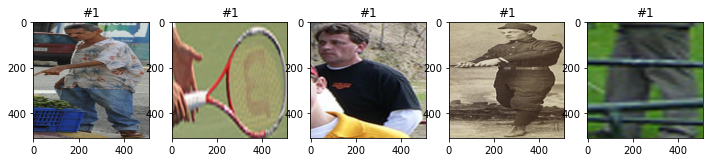

In [27]:
import matplotlib.pyplot as plot

fig = plt.figure(figsize=(12,10))

for idx,img in enumerate(imgs_retrieval):
    ax = fig.add_subplot(1, len(imgs_retrieval), idx+1)
    ax.set_title("#1")
    ax.imshow(img)
plt.show()
